<a href="https://colab.research.google.com/github/mikael-bashir/strange-attractors/blob/google-colab/strange-attractors.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Running on device: cuda
Step 5000/50000  | Hist points: 250,000,000  |  Elapsed: 5.6s
Step 10000/50000  | Hist points: 500,000,000  |  Elapsed: 10.6s
Step 15000/50000  | Hist points: 750,000,000  |  Elapsed: 15.7s
Step 20000/50000  | Hist points: 1,000,000,000  |  Elapsed: 21.2s
Step 25000/50000  | Hist points: 1,250,000,000  |  Elapsed: 26.3s
Step 30000/50000  | Hist points: 1,500,000,000  |  Elapsed: 31.9s
Step 35000/50000  | Hist points: 1,750,000,000  |  Elapsed: 36.9s
Step 40000/50000  | Hist points: 2,000,000,000  |  Elapsed: 42.5s
Step 45000/50000  | Hist points: 2,250,000,000  |  Elapsed: 47.6s
Step 50000/50000  | Hist points: 2,500,000,000  |  Elapsed: 53.0s
Lyapunov exponents:
  λ₁ = 0.565782
  λ₂ = -0.578898
Kaplan–Yorke dimension D_KY = 1.977344


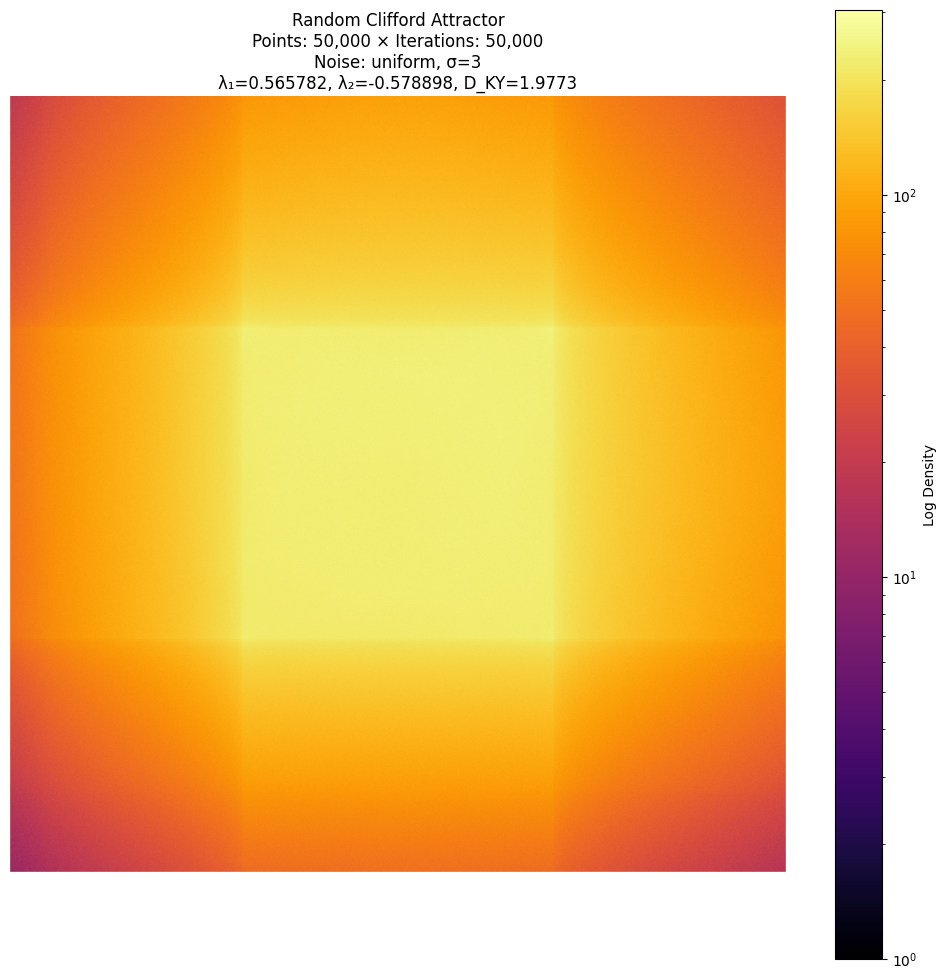

In [2]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import time

# ─────────────────────────────────────────────────────────────────────────────
# CONFIGURATION
# ─────────────────────────────────────────────────────────────────────────────

# Number of iterations (time steps)
n_iter = 50_000

# Number of points (“trajectories”) to evolve in parallel
# Increase to 100 000+ to saturate a T4’s 40 SMs
n_points = 50_000

# Output image resolution
width, height = 4000, 4000

# Base parameters for the Clifford attractor (a, b, c, d).
base_params = torch.tensor([-1.4, 1.6, 1.0, 0.7], device='cuda')

# Range of x, y for scaling into pixel coordinates
x_min, x_max = -2.5, 2.5
y_min, y_max = -2.5, 2.5

# Noise settings
noise_type = 'uniform'    # 'uniform' | 'normal' | 'beta'
noise_level = 3           # Half‐range for uniform, std for normal

# Device check
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Running on device: {device}")

# ─────────────────────────────────────────────────────────────────────────────
# HELPER FUNCTIONS
# ─────────────────────────────────────────────────────────────────────────────

def sample_noise(N, noise_type: str, noise_level: float):
    """
    Return a [N, 4] tensor of noise, depending on noise_type.
    """
    if noise_type == "uniform":
        return (torch.rand((N, 4), device=device) * 2 - 1) * noise_level
    elif noise_type == "normal":
        return torch.randn((N, 4), device=device) * noise_level
    else:  # "beta"
        u = torch.rand((N, 4), device=device)
        v = torch.rand((N, 4), device=device)
        beta_noise = u / (u + v)
        return (beta_noise * 2 - 1) * noise_level


def update_points(x, y, base_params, noise,
                  x_min, x_max, y_min, y_max,
                  width, height):
    """
    Given current x, y (each [N]), and noise [N,4], compute one Clifford‐step
    with noisy parameters. Return:
      - x_new, y_new   : updated coordinates [N]
      - flat_idx       : histogram indices [N] after scaling/clamping to [0..width−1]×[0..height−1]
    """
    # params: [N,4]
    params = base_params.unsqueeze(0) + noise
    a = params[:, 0]
    b = params[:, 1]
    c = params[:, 2]
    d = params[:, 3]

    # Clifford mapping (vectorized over N points):
    x_new = torch.sin(a * y) + c * torch.cos(a * x)
    y_new = torch.sin(b * x) + d * torch.cos(b * y)

    # Scale into pixel coordinates [0..width−1], [0..height−1]
    x_scaled = ((x_new - x_min) / (x_max - x_min) * (width - 1)).clamp(0, width - 1)
    y_scaled = ((y_new - y_min) / (y_max - y_min) * (height - 1)).clamp(0, height - 1)

    x_idx = x_scaled.long()
    y_idx = y_scaled.long()

    flat_idx = y_idx * width + x_idx  # [N]

    return x_new, y_new, flat_idx, a, b, c, d, x_new, y_new


def simulate_random_clifford_with_lyapunov(n_iter, n_points, base_params,
                                           noise_type, noise_level,
                                           width, height,
                                           x_min, x_max, y_min, y_max):
    """
    Simulate the Clifford attractor with noisy parameters and compute:
      - [height, width] histogram of visit counts
      - Lyapunov exponents (λ1, λ2)
      - Kaplan‐Yorke dimension D_KY
    """
    # Allocate tensors on GPU for N parallel points (for histogram)
    x = torch.zeros(n_points, device=device, dtype=torch.float32)
    y = torch.zeros(n_points, device=device, dtype=torch.float32)

    # Use a single “reference” trajectory for Lyapunov calculation
    xL = torch.tensor(0.0, device=device)
    yL = torch.tensor(0.0, device=device)

    # Initialize a small tangent vector v = [v_x, v_y]
    v = torch.randn(2, device=device, dtype=torch.float32)
    v = v / v.norm()

    # Flattened histogram vector of length W×H
    H = width * height
    hist = torch.zeros(H, device=device, dtype=torch.int32)

    # Accumulators for Lyapunov exponents (on GPU)
    sum_log_norm = torch.tensor(0.0, device=device)
    sum_log_det = torch.tensor(0.0, device=device)

    # ── WARM‐UP (discard transients) ───────────────────────────────────────────
    for _ in range(100):
        noise_batch = sample_noise(n_points, noise_type, noise_level)
        x, y, _, _, _, _, _, _, _ = update_points(
            x, y, base_params, noise_batch,
            x_min, x_max, y_min, y_max, width, height
        )
        # Reference trajectory warm‐up
        noiseL = sample_noise(1, noise_type, noise_level).squeeze(0)
        aL, bL, cL, dL = (base_params + noiseL).unbind(0)
        xL = torch.sin(aL * yL) + cL * torch.cos(aL * xL)
        yL = torch.sin(bL * xL) + dL * torch.cos(bL * yL)

    # ── MAIN LOOP ───────────────────────────────────────────────────────────────
    start_time = time.time()
    for step in range(n_iter):
        # 1) Histogram trajectories (N points)
        noise_batch = sample_noise(n_points, noise_type, noise_level)
        x, y, flat_idx, _, _, _, _, _, _ = update_points(
            x, y, base_params, noise_batch,
            x_min, x_max, y_min, y_max, width, height
        )
        ones = torch.ones_like(flat_idx, dtype=torch.int32, device=device)
        hist.index_add_(0, flat_idx, ones)

        # 2) Evolve reference trajectory + compute Jacobian J_t at (xL, yL)
        noiseL = sample_noise(1, noise_type, noise_level).squeeze(0)
        aL, bL, cL, dL = (base_params + noiseL).unbind(0)

        # Current point (xL, yL)
        xL_old, yL_old = xL, yL
        xL = torch.sin(aL * yL_old) + cL * torch.cos(aL * xL_old)
        yL = torch.sin(bL * xL_old) + dL * torch.cos(bL * yL_old)

        # Jacobian entries at old point
        # J = [[∂x_new/∂x, ∂x_new/∂y], [∂y_new/∂x, ∂y_new/∂y]]
        J11 = -cL * aL * torch.sin(aL * xL_old)
        J12 =        aL * torch.cos(aL * yL_old)
        J21 =        bL * torch.cos(bL * xL_old)
        J22 = -dL * bL * torch.sin(bL * yL_old)

        # 3) Evolve tangent vector v_{t+1} = J_t · v_t
        v_new = torch.stack([J11 * v[0] + J12 * v[1],
                             J21 * v[0] + J22 * v[1]])
        norm_v_new = v_new.norm()
        v = v_new / norm_v_new        # Renormalize for next step
        sum_log_norm = sum_log_norm + torch.log(norm_v_new.abs() + 1e-16)

        # 4) Accumulate log|det(J_t)| = log|J11*J22 − J12*J21|
        detJ = (J11 * J22 - J12 * J21).abs() + 1e-16
        sum_log_det = sum_log_det + torch.log(detJ)

        # 5) Progress report
        if (step + 1) % (n_iter // 10) == 0:
            elapsed = time.time() - start_time
            total_pts = hist.sum().item()
            print(f"Step {step + 1}/{n_iter}  | "
                  f"Hist points: {total_pts:,}  |  Elapsed: {elapsed:.1f}s")

    # ── COMPUTE LYAPUNOV SPECTRUM ──────────────────────────────────────────────
    λ1 = (sum_log_norm / n_iter).item()
    λ_sum = (sum_log_det / n_iter).item()
    λ2 = λ_sum - λ1

    # Kaplan–Yorke dimension (for 2D: D_KY = 1 + λ1/|λ2|, if λ1>0)
    if λ1 > 0:
        D_KY = 1 + λ1 / abs(λ2)
    else:
        D_KY = 0.0

    # Move histogram back to CPU and reshape to [H×W]
    hist_np = hist.cpu().numpy().reshape((height, width))

    return hist_np, (λ1, λ2, D_KY)


# ─────────────────────────────────────────────────────────────────────────────
# RUN SIMULATION & VISUALIZE
# ─────────────────────────────────────────────────────────────────────────────

hist, (λ1, λ2, D_KY) = simulate_random_clifford_with_lyapunov(
    n_iter=n_iter,
    n_points=n_points,
    base_params=base_params,
    noise_type=noise_type,
    noise_level=noise_level,
    width=width,
    height=height,
    x_min=x_min,
    x_max=x_max,
    y_min=y_min,
    y_max=y_max,
)

# Display Lyapunov data
print(f"Lyapunov exponents:\n  λ₁ = {λ1:.6f}\n  λ₂ = {λ2:.6f}")
print(f"Kaplan–Yorke dimension D_KY = {D_KY:.6f}")

# Plot the density histogram
plt.figure(figsize=(10, 10), dpi=100)
plt.imshow(hist.T,
           origin='lower',
           cmap='inferno',
           norm=LogNorm(vmin=1, vmax=np.percentile(hist[hist > 0], 99.9)))
plt.colorbar(label='Log Density')
plt.title(
    f'Random Clifford Attractor\n'
    f'Points: {n_points:,} × Iterations: {n_iter:,}\n'
    f'Noise: {noise_type}, σ={noise_level}\n'
    f'λ₁={λ1:.6f}, λ₂={λ2:.6f}, D_KY={D_KY:.4f}'
)
plt.axis('off')
plt.tight_layout()
plt.show()
